In [11]:
"""
Imports
"""
import numpy as np
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

In [4]:
"""
# object points represent the object's x,y,z coordinates in the real world,
as opposd to coordinates in the camera image.
Since the chessboard is 9 x 6, we will have 9*6 = 54 points, each with 3 coordinates.

Set the x,y coordinates to all the possible coordinates where
x ranges from 0 to 8 (left to right)
y ranges from 0 to 5 (top to bottom)
"""
objp = np.zeros((6*9,3), np.float32)
objp[0:2]

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)

In [15]:
"""
The next few steps are getting all combinations of x,y coordinates
where x is from 0 to 8 and y is from 0 to 5.
numpy.mgrid gives us a 2 x 9 x 6, where the 2 is for the x and the y coordinates
"""
objp_tmp = np.mgrid[0:9, 0:6]
objp_tmp

array([[[0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8]],

       [[0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4, 5]]])

In [16]:
objp_tmp.shape

(2, 9, 6)

In [17]:
"""
Taking the transpose gives us a 6 x 9 x 2, so the x,y coordinates
are now paired together
"""
objp_tmp = objp_tmp.T
objp_tmp

array([[[0, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0],
        [5, 0],
        [6, 0],
        [7, 0],
        [8, 0]],

       [[0, 1],
        [1, 1],
        [2, 1],
        [3, 1],
        [4, 1],
        [5, 1],
        [6, 1],
        [7, 1],
        [8, 1]],

       [[0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [5, 2],
        [6, 2],
        [7, 2],
        [8, 2]],

       [[0, 3],
        [1, 3],
        [2, 3],
        [3, 3],
        [4, 3],
        [5, 3],
        [6, 3],
        [7, 3],
        [8, 3]],

       [[0, 4],
        [1, 4],
        [2, 4],
        [3, 4],
        [4, 4],
        [5, 4],
        [6, 4],
        [7, 4],
        [8, 4]],

       [[0, 5],
        [1, 5],
        [2, 5],
        [3, 5],
        [4, 5],
        [5, 5],
        [6, 5],
        [7, 5],
        [8, 5]]])

In [18]:
objp_tmp.shape

(6, 9, 2)

In [19]:
"""
In order to flatten this 3d matrix to a 2D,
We specify that the inner-most dimension have 2 values (x,y),
and the outer dimension is however many rows that exist for
6 x 9 coordinates (54)
"""
objp_tmp = objp_tmp.reshape(-1,2)
objp_tmp

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [5, 0],
       [6, 0],
       [7, 0],
       [8, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [5, 1],
       [6, 1],
       [7, 1],
       [8, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [4, 2],
       [5, 2],
       [6, 2],
       [7, 2],
       [8, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [3, 3],
       [4, 3],
       [5, 3],
       [6, 3],
       [7, 3],
       [8, 3],
       [0, 4],
       [1, 4],
       [2, 4],
       [3, 4],
       [4, 4],
       [5, 4],
       [6, 4],
       [7, 4],
       [8, 4],
       [0, 5],
       [1, 5],
       [2, 5],
       [3, 5],
       [4, 5],
       [5, 5],
       [6, 5],
       [7, 5],
       [8, 5]])

In [20]:
objp_tmp.shape

(54, 2)

In [21]:
"""
Finally, set the first 2 values of objp, which are the x,y coordinates.
Notice that the 3rd z coordinate remains zero for all coordinates
"""
objp[:,:2] = objp_tmp
objp

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 3.,  0.,  0.],
       [ 4.,  0.,  0.],
       [ 5.,  0.,  0.],
       [ 6.,  0.,  0.],
       [ 7.,  0.,  0.],
       [ 8.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 3.,  1.,  0.],
       [ 4.,  1.,  0.],
       [ 5.,  1.,  0.],
       [ 6.,  1.,  0.],
       [ 7.,  1.,  0.],
       [ 8.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 3.,  2.,  0.],
       [ 4.,  2.,  0.],
       [ 5.,  2.,  0.],
       [ 6.,  2.,  0.],
       [ 7.,  2.,  0.],
       [ 8.,  2.,  0.],
       [ 0.,  3.,  0.],
       [ 1.,  3.,  0.],
       [ 2.,  3.,  0.],
       [ 3.,  3.,  0.],
       [ 4.,  3.,  0.],
       [ 5.,  3.,  0.],
       [ 6.,  3.,  0.],
       [ 7.,  3.,  0.],
       [ 8.,  3.,  0.],
       [ 0.,  4.,  0.],
       [ 1.,  4.,  0.],
       [ 2.,  4.,  0.],
       [ 3.,  4.,  0.],
       [ 4.,  4.,  0.],
       [ 5.,  4.

In [22]:
objp.shape

(54, 3)

In [26]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
images

['camera_cal/calibration1.jpg',
 'camera_cal/calibration10.jpg',
 'camera_cal/calibration11.jpg',
 'camera_cal/calibration12.jpg',
 'camera_cal/calibration13.jpg',
 'camera_cal/calibration14.jpg',
 'camera_cal/calibration15.jpg',
 'camera_cal/calibration16.jpg',
 'camera_cal/calibration17.jpg',
 'camera_cal/calibration18.jpg',
 'camera_cal/calibration19.jpg',
 'camera_cal/calibration2.jpg',
 'camera_cal/calibration20.jpg',
 'camera_cal/calibration3.jpg',
 'camera_cal/calibration4.jpg',
 'camera_cal/calibration5.jpg',
 'camera_cal/calibration6.jpg',
 'camera_cal/calibration7.jpg',
 'camera_cal/calibration8.jpg',
 'camera_cal/calibration9.jpg']

In [38]:
len(images)

20

In [39]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    #print(corners)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
           
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        #cv2.waitKey(500)
    else:
        print("could not find corners for {}".format(fname))
    """
    """
cv2.destroyAllWindows()

could not find corners for camera_cal/calibration1.jpg
could not find corners for camera_cal/calibration4.jpg
could not find corners for camera_cal/calibration5.jpg


In [54]:
"""
Now objpoints has 17 copies of the points in the 'real world'
and imgpoints has 17 sets of coordinates for the found corners.
There are 9 * 6 = 54 corners for each set.  
Each corner is represented by two coordinates (x,y)

Using the sets of image and real points, we can calibrate the camera.

The camera calibration gives us matrices and vectors that are 
used to undistort any image taken with the same camera 
(the image size is also needed for calibration)

"""
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [56]:
#ret != 0 is True
ret

1.1868973603423718

In [57]:
mtx

array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
       [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [58]:
dist

array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]])

In [59]:
#rotation vectors
rvecs

[array([[ 0.50716545],
        [-0.22122219],
        [ 0.02988717]]), array([[ 0.03492402],
        [ 0.45739729],
        [ 0.00492867]]), array([[ 0.03471112],
        [ 0.65086688],
        [ 0.00971071]]), array([[-0.33084415],
        [ 0.65914967],
        [-0.41537657]]), array([[ 0.05531879],
        [-0.51892709],
        [-0.00398629]]), array([[-0.02434082],
        [-0.48814782],
        [ 0.0205404 ]]), array([[ 0.04125139],
        [-0.46371786],
        [-0.05619974]]), array([[ 0.21226762],
        [-0.067192  ],
        [ 0.0124846 ]]), array([[ 0.17850283],
        [-0.06187035],
        [ 0.00114955]]), array([[ 0.08447458],
        [ 0.38039934],
        [ 0.05427302]]), array([[ 0.63236599],
        [-0.04827079],
        [ 0.01721011]]), array([[-0.02563264],
        [ 0.38170173],
        [-0.00443487]]), array([[-0.44823487],
        [-0.06589252],
        [-0.01933811]]), array([[ 0.01805199],
        [ 0.02669678],
        [-0.00551439]]), array([[ 0.0178336 

In [60]:
#translation vectors
tvecs

[array([[ -2.11922855],
        [ -0.71465388],
        [ 19.53183554]]), array([[-16.99963028],
        [ -3.45711062],
        [ 31.88140225]]), array([[ -0.21898193],
        [ -3.45905797],
        [ 21.82352738]]), array([[ -6.06136681],
        [ -1.54277113],
        [ 26.6077651 ]]), array([[  5.35073144],
        [ -4.43439198],
        [ 20.69860635]]), array([[  4.46791786],
        [ -1.45553778],
        [ 19.91167384]]), array([[  4.86295442],
        [ -5.0332483 ],
        [ 19.69539304]]), array([[ -3.98286443],
        [ -1.31029172],
        [ 16.98785567]]), array([[ -3.63923607],
        [ -4.12214649],
        [ 17.72145269]]), array([[-13.0435234 ],
        [ -5.57212836],
        [ 23.64304788]]), array([[-3.83498058],
        [-1.59623848],
        [ 7.94136389]]), array([[-13.43070279],
        [ -0.45669297],
        [ 24.41876447]]), array([[ -4.40335216],
        [ -3.04835705],
        [ 10.68886726]]), array([[ -4.97952826],
        [ -3.83821782],
      

In [68]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_pickle.p", "wb" ) )

In [70]:
#loading dist_pickle from pickle file
import pickle
dist_pickle = pickle.load( open( "camera_cal/camera_pickle.p", "rb" ) )
dist_pickle

{'dist': array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
          -1.28318856e-04,   2.67125290e-02]]),
 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
        [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}

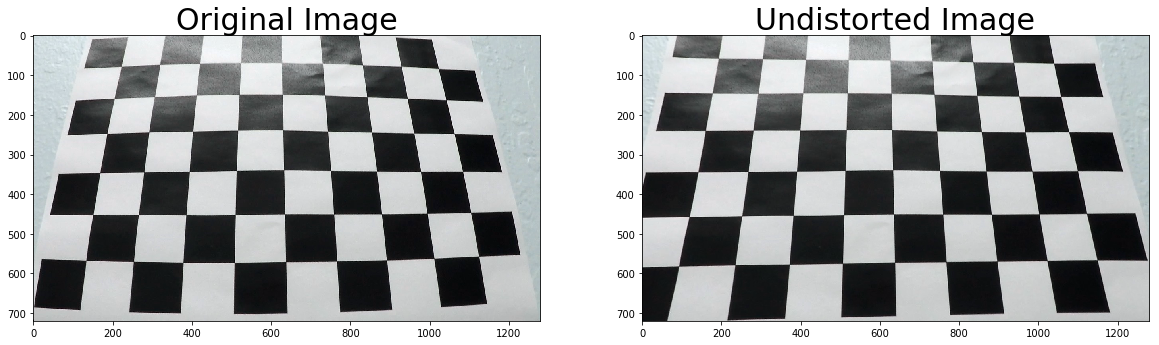

In [69]:
dst = cv2.undistort(img, dist_pickle['mtx'], dist_pickle['dist'], None, dist_pickle['mtx'])
cv2.imwrite('output_images/test_undist_3.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(dst);
ax2.set_title('Undistorted Image', fontsize=30);

In [18]:
import pickle
import sys

def undistort_image(x_count, y_count, img, use_cache=True, image_dir='camera_cal/calibration*.jpg'):
    """
    Get the mtx and dist matrices that are used to undistort an image.
    Either load these from a saved cache, or calculate them if needed.
    
    x_count: number of inside corners in x direction (left to right)
    y_count: number of inside corners in y direction (top to bottom)
    image_dir: path where chess board images are located: 'camera_cal/*.jpg'
    img_size: can either be (width, height), or (height, width). Both appear to work
    img: distorted image to undistort
    
    Returns:
    undist: undistorted image
    """
    pickle_path = "camera_cal/camera_pickle.p"
    if use_cache:
        try:
            dist_pickle = pickle.load( open( pickle_path, "rb" ) )
            print("using cached mtx, dst values to undistort image")
            return cv2.undistort(img, dist_pickle['mtx'], dist_pickle['dist'], None, dist_pickle['mtx'])
        except:
            print("error loading mtx and dst from cache, recalculating them...{}".format(sys.exc_info()))
    else:
        print("recalculating mtx and dst...")
    
    
    objp = np.zeros((x_count*y_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:x_count, 0:y_count].T.reshape(-1,2)
    images = glob.glob(image_dir)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img_tmp = cv2.imread(fname)
        gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x_count,y_count), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print("could not find corners for {}".format(fname))
    
    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    if ret:
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( pickle_path, "wb" ) )
        return cv2.undistort(img, mtx, dist, None, mtx)
    else:
        print("could not calibrate camera")
        return None

recalculating mtx and dst...
could not find corners for camera_cal/calibration1.jpg
could not find corners for camera_cal/calibration4.jpg
could not find corners for camera_cal/calibration5.jpg


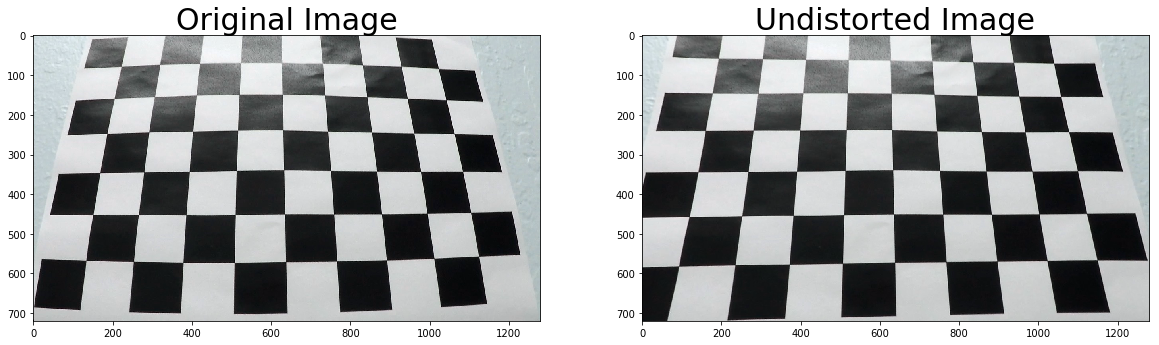

In [19]:
img = cv2.imread('camera_cal/calibration3.jpg')
dst = undistort_image(x_count=9,
                      y_count=6,
                      img=img,
                      use_cache=False,
                      image_dir='camera_cal/calibration*.jpg')
cv2.imwrite('camera_cal/test_undist_3.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(dst);
ax2.set_title('Undistorted Image', fontsize=30);

using cached mtx, dst values to undistort image


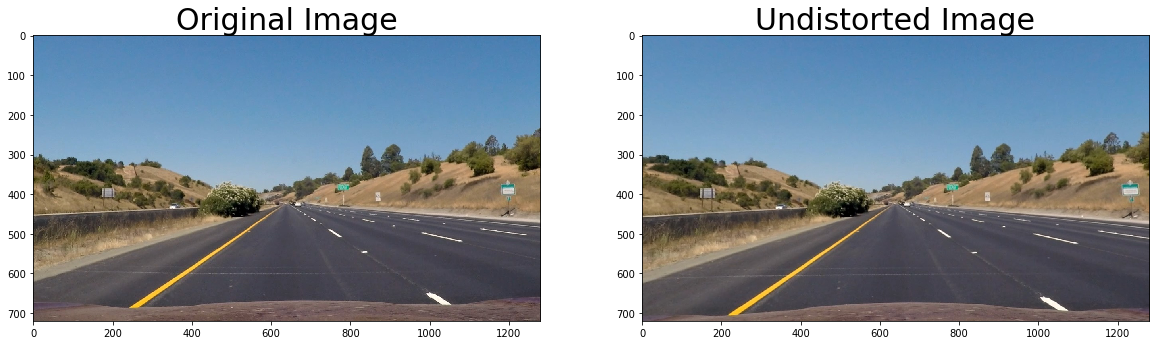

In [107]:
"""
undistort a road image
"""
import cv2
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')
cv2.imwrite('/output_images/road_undistorted.jpg',undist)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Undistorted Image', fontsize=30);

## Binarize image

In [110]:
def abs_sobel_thresh(img, sobel_kernel=3, threshx=(50, 100),threshy=(50, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    scaled_sobelx = np.uint8(255 * np.absolute(sobelx) / np.max(np.absolute(sobelx)))
    scaled_sobely = np.uint8(255 * np.absolute(sobely) / np.max(np.absolute(sobely)))
    grad_binaryx, grad_binaryy = np.zeros_like(scaled_sobelx), np.zeros_like(scaled_sobely)
    grad_binaryx[(scaled_sobelx >= threshx[0]) & (scaled_sobelx < threshx[1])] = 1
    grad_binaryy[(scaled_sobely >= threshy[0]) & (scaled_sobely < threshy[1])] = 1
    return grad_binaryx, grad_binaryy

def mag_thresh(image, sobel_kernel=3, mag_thresh=(80, 120)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255 * mag / np.max(mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/4)):
    """
    by default, I'll have it look for gradients that are between 0 and 45 degrees
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    theta = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(theta)
    dir_binary[(theta >= thresh[0]) & (theta < thresh[1])] = 1
    return dir_binary

using cached mtx, dst values to undistort image


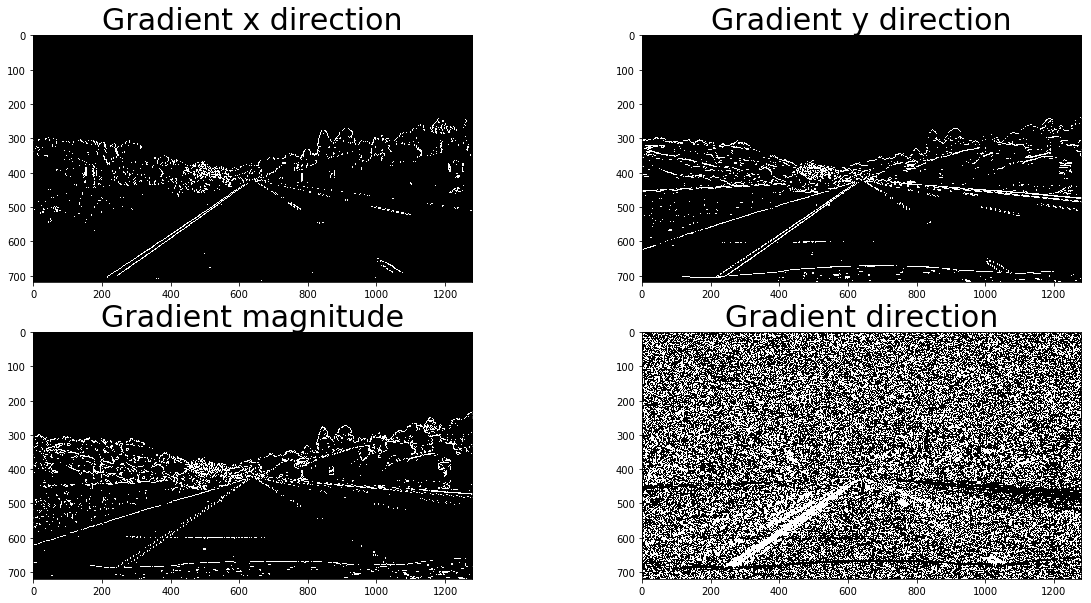

In [169]:
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

# Choose a Sobel kernel size
ksize = 5# Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=ksize, threshx=(30, 120), threshy=(30,120))
mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 80))
dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(gradx, cmap='gray');
ax1.set_title('Gradient x direction', fontsize=30);
ax2.imshow(grady, cmap='gray');
ax2.set_title('Gradient y direction', fontsize=30);
ax3.imshow(mag_binary, cmap='gray');
ax3.set_title('Gradient magnitude', fontsize=30);
ax4.imshow(dir_binary, cmap='gray');
ax4.set_title('Gradient direction', fontsize=30);

In [144]:
def red_thresh(img, thresh=(200,255)):
    """
    img: image is in RGB
    """
    r = img[:,:,0] #get red
    red_binary = np.zeros_like(r)
    red_binary[ (r >= thresh[0]) & (r < thresh[1])] = 1
    return red_binary

def saturation_thresh(img, thresh=(90,255)):
    """
    Assume img is RGB
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[ (s >= thresh[0]) & (s < thresh[1]) ] = 1
    return s_binary

using cached mtx, dst values to undistort image


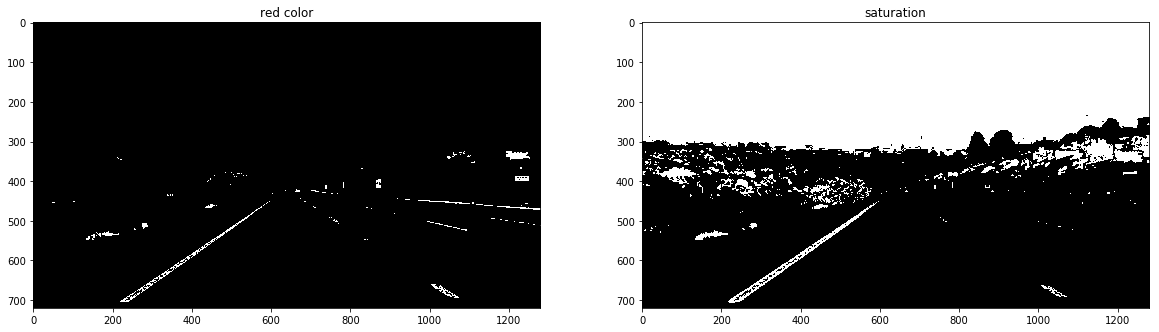

In [170]:
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

red_binary = red_thresh(undist, thresh=(200,255))
s_binary = saturation_thresh(undist, thresh=(90,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(red_binary, cmap='gray');
ax1.set_title("red color");
ax2.imshow(s_binary, cmap = 'gray');
ax2.set_title("saturation");

using cached mtx, dst values to undistort image


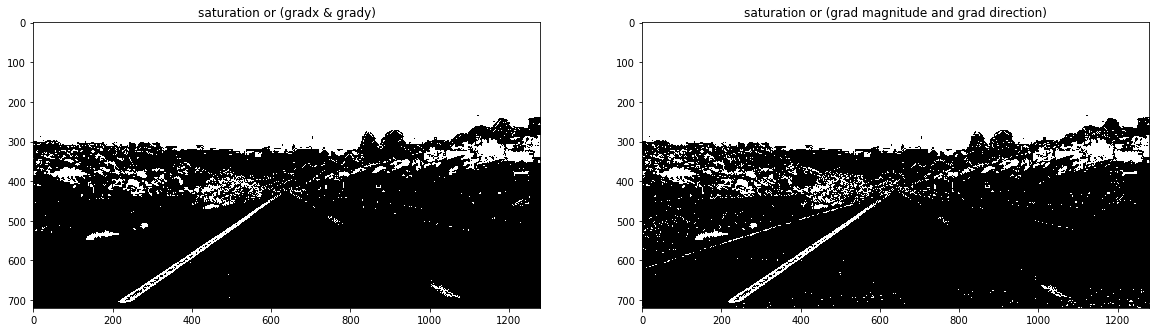

In [171]:
"""
Combine thresholds 

x threshold looks the cleanest of the gradient thresholds.
saturation is better than red
"""
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')


combo_binary1 = np.zeros_like(s_binary)
combo_binary1[ (s_binary == 1) | ((gradx == 1) & (grady == 1)) ] = 1

combo_binary2 = np.zeros_like(s_binary)
combo_binary2[ (s_binary == 1) | ((dir_binary == 1) & (mag_binary==1)) ] = 1

cv2.imwrite('/output_images/road_binarized.jpg',combo_binary1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));

ax1.imshow(combo_binary1, cmap='gray');
ax1.set_title("saturation or (gradx & grady)");
ax2.imshow(combo_binary2, cmap = 'gray');
ax2.set_title("saturation or (grad magnitude and grad direction)");

## Pespective transform

In [100]:
def transform_perspective(img):
    """
    img: input image that should already be undistorted
    
    """
    h, w = img.shape[0:2] #dim 0 is height, dim 1 is width
    img_size = (w, h) #flip order so that 0th dim is x axis (left/right), 1st dim is y axis (up/down)
    #points are (width, height)
    src_points = np.float32(
        [[(w / 2) - 60, h / 2 + 100], #top left
        [((w / 6) - 10), h], #bottom left
        [(w * 5 / 6) + 60, h], #bottom right
        [(w / 2 + 60), h / 2 + 100]]) #top right
    
    dst_points = np.float32(
        [[(w / 4), 5], #top left
        [(w / 4), h-5], #bottom left
        [(w * 3 / 4), h-5], #bottom right
        [(w * 3 / 4), 5]]) #top right

    M = cv2.getPerspectiveTransform(src_points, dst_points)

    #notice that for warpPerspective, the image size should be (width, height), or (x, y)
    warped = cv2.warpPerspective(img, M, img_size)

    return warped, src_points, dst_points

using cached mtx, dst values to undistort image


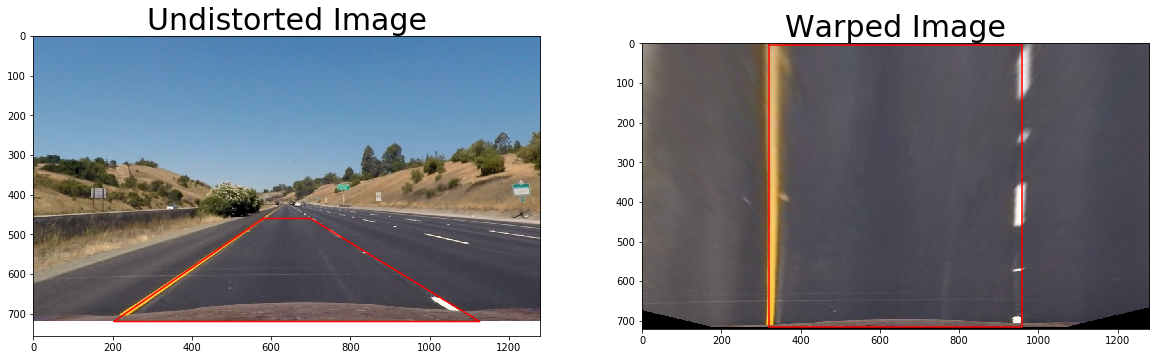

In [172]:
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

warped, src_points, dst_points = transform_perspective(undist)
cv2.imwrite('/output_images/road_warped.jpg',warped)
# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(dst);
ax1.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(warped);
ax2.set_title('Warped Image', fontsize=30);
ax2.plot([dst_points[0,0],dst_points[1,0],dst_points[2,0],dst_points[3,0],dst_points[0,0]],
         [dst_points[0,1],dst_points[1,1],dst_points[2,1],dst_points[3,1],dst_points[0,1]], color='red');

using cached mtx, dst values to undistort image


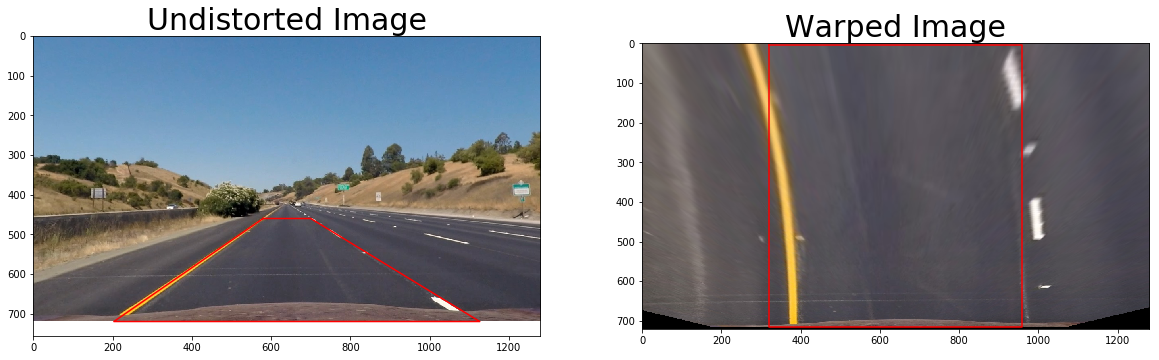

In [164]:
"""
Try the same perspective transform on a curved road
"""
img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

warped, src_points, dst_points = transform_perspective(undist)
cv2.imwrite('/output_images/road_curved_warped.jpg',warped)
# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(undist);
ax1.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(warped);
ax2.set_title('Warped Image', fontsize=30);
ax2.plot([dst_points[0,0],dst_points[1,0],dst_points[2,0],dst_points[3,0],dst_points[0,0]],
         [dst_points[0,1],dst_points[1,1],dst_points[2,1],dst_points[3,1],dst_points[0,1]], color='red');

## Undistort, Threshold, and Perspective Transform

using cached mtx, dst values to undistort image


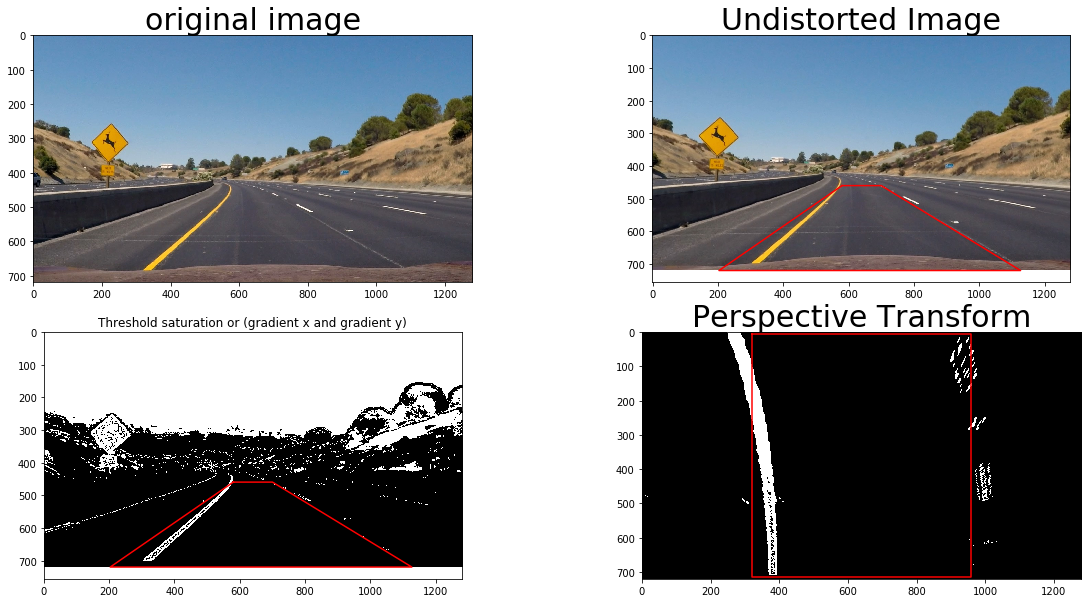

In [173]:
img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

gradx, grady = abs_sobel_thresh(undist, sobel_kernel=ksize, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | ((gradx == 1) & (grady == 1)) ] = 1

warped, src_points, dst_points = transform_perspective(combo_binary)
cv2.imwrite('/output_images/road_curved_binarized.jpg',combo_binary)
cv2.imwrite('/output_images/road_curved_binarized_warped.jpg',warped)

# Visualize perspective transform
f, ((ax1, ax2), (ax3,ax4))= plt.subplots(2, 2, figsize=(20,10));

ax1.imshow(img);
ax1.set_title("original image", fontsize=30);

ax2.imshow(undist);
ax2.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');
ax2.set_title('Undistorted Image', fontsize=30);

ax3.imshow(combo_binary, cmap='gray');
ax3.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');

ax3.set_title("Threshold saturation or (gradient x and gradient y)");

ax4.imshow(warped, cmap='gray');
ax4.set_title('Perspective Transform', fontsize=30);
ax4.plot([dst_points[0,0],dst_points[1,0],dst_points[2,0],dst_points[3,0],dst_points[0,0]],
         [dst_points[0,1],dst_points[1,1],dst_points[2,1],dst_points[3,1],dst_points[0,1]], color='red');

## Find Lane Lines

In [235]:
def lane_line(img, nwindows=9, margin=100, minpix = 50, visualize=True):
    """
    img: should be a binary (thresholded) image that is warped to show an aerial view
    nwindows: numer of sliding windows, stacked horizontally, to use when searching for lane lines
    margin: the width of the windows +/- margin
    minpix: minimum number of pixels found to recenter window
    """
    mid_height = np.int(img.shape[0] / 2)
    bottom_half = img[mid_height:,:]
    """
    #choose axis 0. the image's 0th dimension is height,
    so the outer nesting is for an entire row with multiple columns.
    Summing along axis 0 means sum all rows for each column
    """
    histogram = np.sum(bottom_half, axis=0) #histogram is 1D and same as width of image
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255 #the shape is height (720) x width (1280) x 3 copies of img

    """
    Find the peak of the left and right halves of the histogram
    These will be the starting point for the left and right lines
    """
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    """
    Identify the x and y positions of all nonzero pixels in the image
    nonzeroy has 1 element for each pixel in the image where the pixel
    is nonzero.  So, for instance, out of (270 * 1280) = 345,600 total pixels,
    28,357 (len(nonzeroy)) of those have non-zero values.  nonzeroy has the y coordinate of each of those nonzero pixels.
    Similarly, nonzerox has the x coordinates of each of those nonzero pixels.
    The nonzeroy and nonzerox are ordered so that nonzeroy[10] and nonzeroy[10] represent the y and x coordinates
    of a pixel that has a nonzero value.
    """
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0]) 
    nonzerox = np.array(nonzero[1])
    
    """
    Loop through all windows
    """
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base


    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    img_height = binary_warped.shape[0]

    #before loop, copy some shape values to local vars for easier reading
    img_height = binary_warped.shape[0]
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_high = img_height - window*window_height #this is the bottom of the window
        win_y_low = win_y_high - window_height #this is the top of the window
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        """
        # Draw the windows on the visualization image
        # two diagonal corners are given to define the rectangle:
        #top left corner, bottom right corner (of the left lane's window)
        #same for the right lane's window
        """
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        """
        Identify the nonzero pixels in x and y within the window.
        Recall that nonzeroy's values represent the y coordinates of pixels 
        that have nonzero values in the image.
        We're using the inequalities to find pixels for which the 
        y coordinates and x coordinates are within the window.
        
        The inequalities give us 1 for true and 0 for false.  
        We apply nonzero to find the indices for nonzeroy and nonzerox for which 
        the x,y coordinates are both nonzero pixels and are within the window boundaries.
        These indices are saved for the left lane and right lane.
        """
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    #end for loop
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    """
    Extract left and right line pixel positions
    These give us the x, y coordinates of the pixels
    that are nonzero in the image, and are also within the 
    search windows.
    """
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    """
    Fit a second order polynomial to each
    Notice that the y axis is our independent variable,
    since the lane lines are close to vertical, and so there 
    are more than one y value for the same x value.
    We're fitting a second order polynomial, so the coefficients
    will be used like this:
    x = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    """
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize:
        """
        numpy.linspace(start, stop, num=50...)
        """
        ploty = np.linspace(0, height - 1, height )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    

    return left_lane_inds, right_lane_inds, left_fit, right_fit

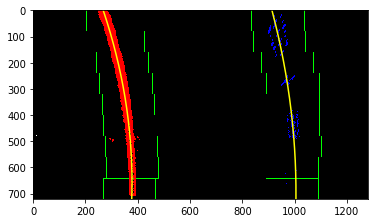

In [236]:
left_lane_inds, right_lane_inds, left_fit, right_fit = lane_line(img=warped, nwindows=9, margin=100, minpix = 50)